In [10]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from gym import spaces

In [ ]:
class CoffeeMachineEnv(gym.Env):
    def __init__(self):
        super(CoffeeMachineEnv, self).__init__()

        # Define state space (5 discrete values)
        self.observation_space = spaces.MultiDiscrete([4, 4, 3, 3, 2])  
        # [Machine status, User input, Water level, Coffee beans, Milk] -> number is amount of categories each element can have e.g. machine status: 0=Idle, 1=Brewing, 2=Dispensing, 3=Waiting for Input

        # Define action space (5 discrete actions) -> Start brewing, Dispense coffee, Add milk, Clean machine, Cancel order
        self.action_space = spaces.Discrete(5)

        # Initial state
        self.state = [0, 0, 2, 2, 1]  # Idle, No user input, Full water, Full beans, Has milk

    def step(self, action):
        print("Action: ", action)
        reward = 0
        done = False

        machine_status, user_input, water_level, coffee_beans, milk_availability = self.state

        # Define how the environment responds to actions
        #if action == 0 and machine_status == 0 and user_input == 1 and water_level > 0 and coffee_beans > 0:
        if action == 0:
            if water_level > 0 and coffee_beans > 0:
                self.state[0] = 1  # Brewing
                self.state[2] = max(0, self.state[2] - 1)  # Reduce water
                self.state[3] = max(0, self.state[3] - 1)  # Reduce coffee beans
                reward = 2
            else:
                self.state[0] = 3  # Waiting for Input
                reward = -1
        elif action == 1 and machine_status == 1:
            self.state[0] = 2  # Dispensing
            reward = 3
        elif action == 2 and self.state[0] == 2 and milk_availability == 1:
            reward = 1  # Add milk successfully
        elif action == 3:
            self.state = [0, 0, 2, 2, 1]  # Reset machine
            reward = 1
            done = True
        elif action == 4:
            reward = -1  # Cancel order = negative reward
            done = True
        else:
            reward = -2  # Invalid action (e.g., trying to brew with no user input)

        return self.state, reward, done, {}

    def reset(self):
        self.state = [0, 0, 2, 2, 1] # Reset the machine to initial state
        return self.state

In [46]:
env = CoffeeMachineEnv()  # Use your custom environment

In [47]:
env = CoffeeMachineEnv()
state = env.reset()
print("Initial State:", state)

for _ in range(5):
    action = env.action_space.sample()  # Random action
    next_state, reward, done, _ = env.step(action)
    print("Next State:", next_state, "Reward:", reward, "Done:", done)

Initial State: [0, 0, 2, 2, 1]
Next State: [0, 0, 2, 2, 1] Reward: -2 Done: False
Next State: [0, 0, 2, 2, 1] Reward: -2 Done: False
Next State: [0, 0, 2, 2, 1] Reward: -2 Done: False
Next State: [0, 0, 2, 2, 1] Reward: -2 Done: False
Next State: [0, 0, 2, 2, 1] Reward: -1 Done: True


In [48]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [58]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 1000

In [50]:
# Initialize Q-networks
input_dim = 5 # Observation space -> the 5 possible inputs [Machine status, User input, Water level, Coffee beans, Milk] 
output_dim = 5 # Action space -> the 5 possible actions [Start brewing, Dispense coffee...] -> for every action a Q value gets calculated, which is the expected reward for taking that action in that state
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [51]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore (random action)
    else:
        state = torch.FloatTensor([state]).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit (best action)

In [52]:
# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Main training loop
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        
        # Store transition in memory
        memory.append((state, action, reward, next_state, done))
        
        # Update state
        state = next_state
        episode_reward += reward
        
        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    
    rewards_per_episode.append(episode_reward)

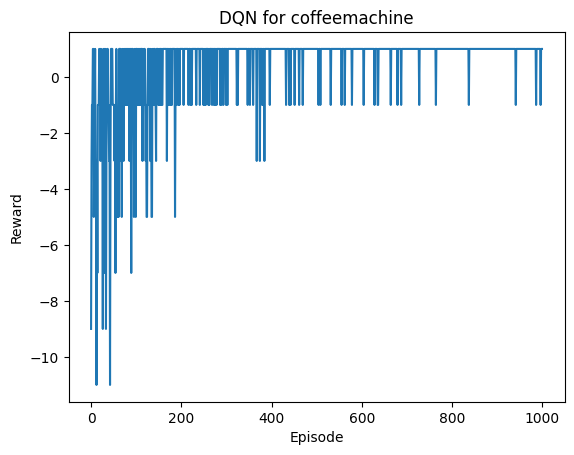

In [60]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN for coffeemachine')
plt.show()